In [2]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import AbstractRNNCell
from tensorflow.keras.layers import RNN
from tensorflow.keras.layers import Conv1D
from tensorflow.keras import activations
from tensorflow.keras import Input

import numpy as np

TensorFlow 2.x selected.


In [0]:
import matplotlib.pyplot as plt

If you want to check if op is run on GPU set following option to be true and run toy example

In [0]:
tf.debugging.set_log_device_placement(False)

You can skip the cell below since Eager Execution is by default enabled

In [0]:
tf.executing_eagerly()

True

In [0]:
def binarize(images):
    return (np.random.uniform(size=images.shape) < images).astype('float32')

In [5]:
def prepare_mnist_features_and_labels(x, y):
    pass

def mnist_dataset(bsize=100, shuffle_buffer_size=1000):
    (x, y), _ = tf.keras.datasets.mnist.load_data()
    x = binarize(np.array(x / 255.0, dtype=np.float32))
    x = np.expand_dims(x, -1)
    #import copy
    #y = copy.deepcopy(x)

    from sklearn.model_selection import train_test_split
    X, Xval, Y, Yval = train_test_split(x, y, test_size=0.2, random_state=1)

    n_tr = X.shape[0]
    n_te = Xval.shape[0]

    #trds = tf.data.Dataset.from_tensor_slices((X, Y))
    trds = tf.data.Dataset.from_tensor_slices((X, X))
    #trds = trds.map(prepare_mnist_features_and_labels)
    trds = trds.take(n_tr).shuffle(shuffle_buffer_size).batch(bsize)

    #teds = tf.data.Dataset.from_tensor_slices((Xval, Yval))
    teds = tf.data.Dataset.from_tensor_slices((Xval, Xval))
    #trds = trds.map(prepare_mnist_features_and_labels)
    teds = teds.take(n_te).shuffle(shuffle_buffer_size).batch(bsize)

    return trds, teds

train_dataset, val_dataset = mnist_dataset(16)


11493376/11490434 [==============================] - 0s 0us/step


In [0]:
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import nn

'''
grayscale은 쉬운데
grayscale부터 해보자!
rgb는 내생각에는
utils에
N, H, W, C --> N,H,W*C로 만들어야할듯
반대 operation도! skew참조

'''

class MaskedConv2D(layers.Conv2D):
    def __init__(self, *args, mask='B', n_channel=3, mono=False, **kargs):
        super(MaskedConv2D,self).__init__(*args,**kargs)
        self.mask_type = mask
        self.mask = None
        self.trainable=True
    
    def build(self, input_shape):
        super(MaskedConv2D, self).build(input_shape)
        if self.data_format == 'channel_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape.dims[channel_axis].value is None:
            raise ValueError('The channel dimension of the inputs '
                           'should be defined. Found `None`.')
        input_dim = int(input_shape[channel_axis])
        kernel_shape = self.kernel_size + (input_dim, self.filters)

        self.mask = np.ones(kernel_shape)

        self.mask[kernel_shape[0]//2,kernel_shape[1]//2 + (self.mask_type == 'B'):,:,:] = 0
        self.mask[kernel_shape[0]//2+1:,:,:,:] = 0

        self.mask = tf.convert_to_tensor(self.mask, dtype=tf.float32)
        self.mask = tf.Variable(self.mask, trainable=False)
        #self.kernel = tf.Variable(self.kernel * self.mask)
        self.built = True
    
    #def call(self, inputs):
    #  return super(MaskedConv2D, self).call(inputs)
  
    '''
    the code snippet below is taken from tf.keras convolutional.py
    '''
    def call(self, inputs):
        outputs = self._convolution_op(inputs, self.kernel * self.mask)

        if self.use_bias:
            if self.data_format == 'channels_first':
                if self.rank == 1:
                    # nn.bias_add does not accept a 1D input tensor.
                    bias = array_ops.reshape(self.bias, (1, self.filters, 1))
                    outputs += bias
                else:
                    outputs = nn.bias_add(outputs, self.bias, data_format='NCHW')
            else:
                outputs = nn.bias_add(outputs, self.bias, data_format='NHWC')

        if self.activation is not None:
            return self.activation(outputs)
        return outputs
    


In [0]:
 class MaskedConv1D(layers.Conv1D):
    def __init__(self, *args, mask='B', n_channel=3, mono=False, **kargs):
        super(MaskedConv1D, self).__init__(*args,**kargs)
        self.mask_type = mask
        self.mask = None
        self.trainable=True
    
    def build(self, input_shape):
        super(MaskedConv1D, self).build(input_shape)
        if self.data_format == 'channel_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape.dims[channel_axis].value is None:
            raise ValueError('The channel dimension of the inputs '
                           'should be defined. Found `None`.')
        input_dim = int(input_shape[channel_axis])
        kernel_shape = self.kernel_size + (input_dim, self.filters)

        self.mask = np.ones(kernel_shape)

        self.mask[kernel_shape[0]//2 + (self.mask_type == 'B'):,:,:] = 0.
        self.mask = tf.convert_to_tensor(self.mask,dtype=tf.float32)
        self.mask = tf.Variable(self.mask, trainable=False)
        #self.kernel = tf.Variable(self.kernel*self.mask)
        self.built = True
    
    #def call(self, inputs):
    #  return super(MaskedConv1D, self).call(inputs)
  
    '''
    the code snippet below is taken from tf.keras convolutional.py
    '''
    def call(self, inputs):
        outputs = self._convolution_op(inputs, self.kernel * self.mask)

        if self.use_bias:
            if self.data_format == 'channels_first':
                if self.rank == 1:
                    # nn.bias_add does not accept a 1D input tensor.
                    bias = array_ops.reshape(self.bias, (1, self.filters, 1))
                    outputs += bias
                else:
                    outputs = nn.bias_add(outputs, self.bias, data_format='NCHW')
            else:
                outputs = nn.bias_add(outputs, self.bias, data_format='NHWC')

        if self.activation is not None:
            return self.activation(outputs)
        return outputs
  

In [15]:
t = tf.constant(np.arange(1,19,1).reshape(2,3,3))
t

<tf.Tensor: id=36, shape=(2, 3, 3), dtype=int64, numpy=
array([[[ 1,  2,  3],
        [ 4,  5,  6],
        [ 7,  8,  9]],

       [[10, 11, 12],
        [13, 14, 15],
        [16, 17, 18]]])>

In [0]:
# this code is inspired by https://github.com/carpedm20/pixel-rnn-tensorflow/blob/master/ops.py

def skew(inputs, scope='skew'):
    with tf.name_scope(scope):
        batch, height, width, channels = inputs.shape

        rows = tf.split(inputs, height, 1) #(batch, 1, width, channel) * height
        skewed_rows = []

        for idx, row in enumerate(rows):
            skewed_row  = tf.pad(tf.squeeze(row, 1), [[0,0], [idx, width-idx-1], [0,0]])
            skewed_rows.append(skewed_row)

        result = tf.stack(skewed_rows, axis=1)

        return result


def unskew(inputs, scope='unskew'):
    with tf.name_scope(scope):
        batch, height, width, channels = inputs.shape
        width = (width+1)//2

        rows = tf.split(inputs, height, 1) #(batch, 1, 2*width-1, channel) * height
        unskewed_rows = []

        for idx, row in enumerate(rows):
            unskewed_row = tf.slice(tf.squeeze(row, 1), [0, idx, 0], [-1, width, -1])
            unskewed_rows.append(unskewed_row)

        result = tf.stack(unskewed_rows, axis=1)

        return result

In [87]:
t = tf.constant(np.arange(1,37,1).reshape(2,3,3,2))
skew(t)[0,:,:,0]

<tf.Tensor: id=40012, shape=(3, 5), dtype=int64, numpy=
array([[ 1,  3,  5,  0,  0],
       [ 0,  7,  9, 11,  0],
       [ 0,  0, 13, 15, 17]])>

In [0]:
class BiLSTMCell(layers.AbstractRNNCell):
    def __init__(self, hidden_dims, height, *args, **kargs):
        super(BiLSTMCell, self).__init__(*args, **kargs)
        self._hidden_dims = hidden_dims
        self._height = height
        self._num_units = self._hidden_dims * self._height
        self._state_size = self._num_units * 2
        self._output_size = self._num_units

        self.conv_i_s = MaskedConv1D(4 * hidden_dims, 1, mask='B', n_channel=hidden_dims, padding='same')
        self.conv_s_s = Conv1D(4 * hidden_dims, 2, padding='same')
  
    @property
    def state_size(self):
        return self._state_size
  
    @property
    def output_size(self):
        return self._output_size
  
  
    def call(self, inputs, states):
    
        height = self._height
        hidden_dims = self._hidden_dims
        c_prev = states[0][:,:self._num_units] #(batch, height * hidden_dims)
        h_prev = states[0][:,self._num_units:] #(batch, height * hidden_dims)

        h_prev = tf.reshape(h_prev, [-1, height, hidden_dims])
        inputs = tf.reshape(inputs, [-1, height, hidden_dims])

        s_s = tf.transpose(tf.reshape(self.conv_s_s(h_prev), [-1, height, 4, hidden_dims]), perm=[0,2,1,3]) #output_shape == (batch, height, 4*hidden_dims) --reshape & transpose-->(batch, 4, height, hidden_dims)
        i_s = tf.transpose(tf.reshape(self.conv_i_s(inputs), [-1, height, 4, hidden_dims]), perm=[0,2,1,3]) #output_shape == (batch, height, 4*hidden_dims) --reshape & transpose-->(batch, 4, height, hidden_dims)

        s_s = tf.reshape(s_s,[-1,4 * height * hidden_dims])
        i_s = tf.reshape(i_s,[-1,4 * height * hidden_dims])
        lstm = tf.sigmoid(s_s+i_s)

        i, g, f, o = tf.split(lstm, 4, 1)

        c = f * c_prev + i * g
        h = tf.multiply(o, tf.tanh(c), name='hid') #그냥 *로 해도되는데, name을 주기 위해서?

        new_state = tf.concat([c,h], 1)
        return h, new_state

In [0]:
def reverse(inputs):
  #inputs == (batch, height, width, channels)
  return tf.reverse(inputs, axis=[2])

In [90]:
t = tf.constant(np.arange(1,37,1).reshape(2,3,3,2))
skew(reverse(t))[0,:,:,0]

<tf.Tensor: id=40034, shape=(3, 5), dtype=int64, numpy=
array([[ 5,  3,  1,  0,  0],
       [ 0, 11,  9,  7,  0],
       [ 0,  0, 17, 15, 13]])>

In [0]:
class DiagonalBiLSTM(tf.keras.Model):
    def __init__(self, hidden_dims, width, height, channels, layers=1, *args, **kargs):
        super(DiagonalBiLSTM, self).__init__(*args, **kargs)

        self._width = width
        self._height = height
        self._channels = channels
        self._hidden_dims = hidden_dims    

        self.conv7_7 = MaskedConv2D(hidden_dims, (7,7), n_channel=1, mask='A', padding='same')
        if layers > 1:
            self.bilstm = RNN([BiLSTMCell(hidden_dims, height) for _ in range(layers)], return_sequences=True)
            self.bilstm_reverse = RNN([BiLSTMCell(hidden_dims, height) for _ in range(layers)], return_sequences=True)
        else:
            self.bilstm = RNN(BiLSTMCell(hidden_dims, height), return_sequences=True)
            self.bilstm_reverse = RNN(BiLSTMCell(hidden_dims, height), return_sequences=True)

        self.conv_1_32 = Conv2D(32, (1,1), padding='same', activation='relu')
        self.conv_1_1 = Conv2D(1, (1,1), padding='same')
    
      
    def call(self, x):
        #x --> (batch, height, width, channels)
        batch, height, width, channels = x.shape
        hidden_dims = self._hidden_dims
        out = self.conv7_7(x) # --> (batch, height, width, hidden_dims)
        out_reversed = reverse(out)  # --> (batch, height, width, hidden_dims)

        out_forward = tf.reshape(tf.transpose(skew(out), perm=[0,2,1,3]), [-1, 2*width-1, height*hidden_dims])# --> (batch, 2*width-1, height*hidden_dims)
        out_reversed = tf.reshape(tf.transpose(skew(out_reversed), perm=[0,2,1,3]), [-1, 2*width-1, height*hidden_dims]) # --> (batch, 2*width-1, height*hidden_dims)


        out_forward = tf.transpose(tf.reshape(self.bilstm(out_forward), [-1, self._width*2-1, self._height, self._hidden_dims]), perm=[0,2,1,3]) #(batch, 2*width-1, height*hidden_dims) --> (batch, height, 2*width-1, hid)
        out_reverse = tf.transpose(tf.reshape(reverse(self.bilstm_reverse(out_reversed)), [-1, self._width*2-1, self._height, self._hidden_dims]), perm=[0,2,1,3])

        out_forward = unskew(out_forward)

        out_reverse = unskew(out_reverse) #(batch, height, width, hidden_dims)

        out_reverse_shifted = tf.slice(tf.pad(out_reverse, [[0,0],[0,0],[0,1],[0,0]]), [0,0,1,0], [-1, -1, -1, -1])

        out = out_forward + out_reverse - out_reverse_shifted

        out = self.conv_1_32(out)
        out = self.conv_1_1(out)

        return activations.sigmoid(out)
    
  
    def compute_output_shape(self, input_shape):
        pass

In [0]:
HIDDEN_DIMS = 16
LAYERS = 2
HEIGHT, WIDTH = (28,28)
CHANNELS = 1

bilstm = DiagonalBiLSTM(HIDDEN_DIMS,WIDTH,HEIGHT,CHANNELS,LAYERS)

In [107]:
bilstm(next(iter(train_dataset))[0])

<tf.Tensor: id=99528, shape=(16, 28, 28, 1), dtype=float32, numpy=
array([[[[0.48980787],
         [0.47708803],
         [0.4704276 ],
         ...,
         [0.46371952],
         [0.4637195 ],
         [0.4512056 ]],

        [[0.4771138 ],
         [0.4702713 ],
         [0.4668972 ],
         ...,
         [0.4637192 ],
         [0.46371925],
         [0.45281506]],

        [[0.47024828],
         [0.46688816],
         [0.46524182],
         ...,
         [0.46371898],
         [0.46371913],
         [0.4528919 ]],

        ...,

        [[0.46372488],
         [0.4637249 ],
         [0.4637249 ],
         ...,
         [0.46371084],
         [0.46371508],
         [0.45287946]],

        [[0.4640932 ],
         [0.46409324],
         [0.46409327],
         ...,
         [0.4640852 ],
         [0.46408817],
         [0.45327845]],

        [[0.46793586],
         [0.4679359 ],
         [0.46793592],
         ...,
         [0.46793595],
         [0.46793595],
         [0.45814365

It seems like TF Eagermode tracks variables once model is built and build() is called when model is actually called

In [0]:
# The compile step specifies the training configuration.
#pixelrnn.compile(optimizer=tf.train.RMSPropOptimizer(0.01),
#              loss='binary_crossentropy',
#              )

# The compile step specifies the training configuration.
bilstm.compile(optimizer=tf.optimizers.RMSprop(0.001),
              loss='binary_crossentropy',
              )


In [109]:
print(bilstm.metrics_names)

['loss']


In [0]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/My Drive/Colab Notebooks/bilstm/model_{epoch}.ckpt', mode='min', monitor='val_loss')
]

In [0]:
bilstm.fit(train_dataset, verbose=1, validation_data=val_dataset, epochs=5, callbacks=callbacks) 

Epoch 1/5
3000/3000 [==============================] - 1186s 395ms/step - loss: 0.0244 - val_loss: 0.0000e+00
Epoch 2/5
3000/3000 [==============================] - 1166s 389ms/step - loss: 1.1211e-04 - val_loss: 1.1274e-04
Epoch 3/5
3000/3000 [==============================] - 1169s 390ms/step - loss: 1.0908e-04 - val_loss: 1.0677e-04
Epoch 4/5
 208/3000 [=>............................] - ETA: 17:17 - loss: 9.5428e-05

In [0]:
check_input = next(iter(train_dataset))[0]

In [0]:
check_input.shape

TensorShape([16, 28, 28, 1])

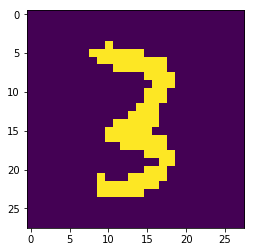

In [0]:
plt.imshow(tf.squeeze(check_input[0]))

In [0]:
pixelrnn.summary()

Model: "pixel_rnn_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masked_conv2d_6 (MaskedConv2 multiple                  3168      
_________________________________________________________________
rnn_3 (RNN)                  multiple                  259840    
_________________________________________________________________
masked_conv2d_7 (MaskedConv2 multiple                  65        
Total params: 263,073
Trainable params: 175,457
Non-trainable params: 87,616
_________________________________________________________________


Another way of training

Using custom train_step decorated with @tf.function

In [0]:
#optimizer = tf.optimizers.Adam(learning_rate=0.01, beta_1=0.99, epsilon=1e-1)
optimizer = tf.optimizers.RMSprop(learning_rate=0.001)

Checkpoint's constructor accepts keyword arguments whose values are types that contain trackable state, such as tf.keras.optimizers.Optimizer implementations, tf.Variable, tf.keras.Layer implementations, or tf.keras.Model implementations. It saves these values with a checkpoint, and maintains a save_counter for numbering checkpoints.

In [0]:
ckpt = tf.train.Checkpoint(pixelrnn=pixelrnn, optimizer=optimizer)

Equivalent to tf.train.latest_checkpoint(directory) where directory is the constructor argument to CheckpointManager.

In [0]:
checkpoint_path = './checkpoint/train'
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [0]:
@tf.function
def train_step(inputs, targets):

    #if len(targets.shape) > 2:
    #  width = targets.shape[-2]
    #  targets = tf.reshape(targets, [-1, width*width])
  
    with tf.GradientTape() as tape:
        logits_ = pixelrnn(inputs)
        #loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=targets, logits=logits_))
        bce = tf.keras.losses.BinaryCrossentropy()
        loss = bce(targets, logits_)
    grads = tape.gradient(loss, pixelrnn.trainable_variables)
    optimizer.apply_gradients(zip(grads, pixelrnn.trainable_variables))
  
    return loss

In [0]:
import random
EPOCHS = 1
BATCH_SIZE = 16
loss_trace = []
import time
for epoch in range(EPOCHS):
  
    total_loss = 0.0
    i=0
    epoch_start = time.time()
    for x,y in train_dataset:
        start=time.time()
        loss = train_step(x,y)

        total_loss += loss
        i += 1

        if i % 100 == 0:
            if i % 500 == 0:
                print('{}% complete'.format(i/30))
            else:
                print('{}% complete'.format(i/30) ,end=' ')

        epoch_elapsed = time.time() - epoch_start
        print("epoch {} : elapsed: {}".format(epoch,epoch_elapsed))
        print("epoch {} : loss: {}".format(epoch,total_loss))

        if (epoch + 1) % 5 == 0:
            ckpt_save_path = ckpt_manager.save()
            print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                             ckpt_save_path))

        loss_trace.append(total_loss)

3.3333333333333335% complete 6.666666666666667% complete 10.0% complete 13.333333333333334% complete 16.666666666666668% complete
20.0% complete 23.333333333333332% complete 26.666666666666668% complete 30.0% complete 33.333333333333336% complete
36.666666666666664% complete 40.0% complete 43.333333333333336% complete 46.666666666666664% complete 50.0% complete
53.333333333333336% complete 56.666666666666664% complete 60.0% complete 63.333333333333336% complete 66.66666666666667% complete
70.0% complete 73.33333333333333% complete 76.66666666666667% complete 80.0% complete 83.33333333333333% complete
86.66666666666667% complete 90.0% complete 93.33333333333333% complete 96.66666666666667% complete 100.0% complete
epoch 0 : elapsed: 720.024587392807
epoch 0 : loss: 709.5159301757812


In [0]:
'''

clone keras model

config = model.get_config()
weights = model.get_weights()

new_model = keras.Model.from_config(config)
new_model.set_weights(weights)
'''

In [0]:
epoch_to_load = 5
chkpoint_path = '/content/drive/My Drive/Colab Notebooks/pixelrnn/model_{}.h5'.format(epoch_to_load)
pixelrnn_loaded = keras.models.load_model(chkpoint_path)

In [0]:
'''
#if you store model in .ckpt format
latest = tf.train.latest_checkpoint('/content/drive/My Drive/Colab Notebooks/pixelrnn/')
# Create a new model instance
pixelrnn_loaded = PixelRNN(HIDDEN_DIMS,WIDTH,HEIGHT,CHANNELS,LAYERS)

# Load the previously saved weights
pixelrnn_loaded .load_weights(latest)
'''

In [0]:
'''
this is also possible
new_model = keras.models.model_from_json(json_config)
new_model.load_weights('path_to_my_weights.h5')
'''

In [0]:
import time

def generate(model, batch=1):
    
    generate_samples = np.zeros((batch,28,28,1), dtype=np.float32)
    import copy
    clone = copy.deepcopy(generate_samples)
    beg = time.time()
    for i in range(28):
        for j in range(28):
            generate_samples[:,i,j,0] = binarize(model(generate_samples).numpy())[:,i,j,0]
      
    elapsed = time.time() - beg
    print("time taken for generation: {}".format(elapsed))
    return clone, generate_samples

In [0]:
org, gen = generate_MNIST(pixelrnn)

543.0113894939423


In [0]:
id(org) == id(gen)

False

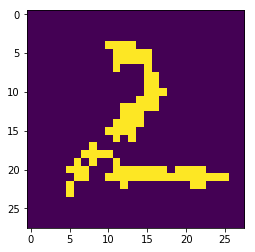

In [0]:
import matplotlib.pyplot as plt

plt.imshow(tf.squeeze(gen[0]))

In [0]:
def generate_occluded(model, occluded_image, occl_row=None):
    if not occl_row:
        print("Specify the occlusion region by passing occl_row, which indicates the first row index under which an occlusion happens")
  
    import copy
    clone = copy.deepcopy(occluded_image)
  
    for i in range(28-occl_row):
        for j in range(28):
            occluded_image[:,occl_row+i,j,:] = binarize(model(occluded_image).numpy())[:,occl_row+i,j,:]
    
    return clone, occluded_image
  